In [1]:
# !pip install openpyxl
# !pip install imbalanced-learn
# !pip3 install ipympl
# !pip install import-ipynb
# !pip install shapely
# !pip install SciencePlots 
# !pip install seaborn
# !pip install tqdm
# !pip install ipywidgets

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import os, sys
from numpy import nan
import re
import ipympl
# from IPython.core.display import display, HTML
import ipywidgets
import json
from os import listdir
import glob
import math
from IPython.display import Image, display, HTML
from shapely.geometry import mapping
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, precision_score, recall_score, mean_absolute_error, make_scorer
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, LeaveOneOut, cross_validate
from sklearn.impute import SimpleImputer
from tqdm.notebook import tqdm
from sklearn.svm import SVC
from tqdm import tqdm
import pickle
from imblearn.over_sampling import SMOTE
from scipy.stats import ks_2samp
from scipy import stats
np.seterr(divide='ignore', invalid='ignore')
pd.options.display.max_columns = 100
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d

In [163]:
import import_ipynb
from SoilPrep import * 

# Step 0: Setting up decision paramenters (Data Tree)

In [164]:
# 1. Available smoothing filter types: savgol1 and savgol2 ------------------------ (1)
sg_filters = ['sg1', 'sg2']

# 2. Available window lengths for the smoothing filter ---------------------------- (2)
window_lengths = [0, 1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101]

# 3. Available preprocessing for Spectral data ------------------------------------ (3)
prepare_spec = ['none', 'fod', 'continuum']
#prepare_spec = ['none', 'fod', 'continuum']

# 4. Number of bands available for resampling spectra ----------------------------- (4) 
nbands_sampling = [0, 10, 20, 50, 100, 200, 500]

# 5. Names of target variables in the dataframe ----------------------------------- (5)
target_names = ['sand', 'silt', 'clay', 'TOC']

# 6. Available preprocessing for Target data -------------------------------------- (6)
prepare_target = ['none', 'minmax']


# 8. Recorded predictions on test-train data for model accuracy  ------------------ (8)
test_train_predict = ['test', 'testP', 'train', 'trainP']

# Step 1a: Spectra Preprocessing (Smooth, FOD/Contin, and Resample)

In [165]:
# Colour scheme definition
kado = '#8B7355'
mati = '#A52A2A'
balu = '#F4A460'

In [166]:
df = pd.read_csv('uae.csv')
spectra = df.iloc[:, 7:2158].copy()

## Savgol smoothing (order 1 and order 2)

In [182]:
# -------------- Smoothed Spectra spec1 (savgol order 1) and spec2 (savgol order 2)  -----------

def filt_sg(spectra, window_len, filt_type):
    sg = filt_type
    w = window_len
    
    if sg == 'sg1':
        if w ==0 or w == 1:
            smth_spec = spectra.copy()   
        else:
            smth_spec = spectra.copy()
            pd.DataFrame(savgol_filter(smth_spec, w, 1, axis=1), columns=smth_spec.columns, index=smth_spec.index)
            
    else:
        if w ==0 or w == 1:
            smth_spec = spectra.copy()   
        else:
            smth_spec = spectra.copy()
            pd.DataFrame(savgol_filter(smth_spec, w, 2, axis=1), columns=smth_spec.columns, index=smth_spec.index)
            
    return (smth_spec)

spec1 = {}
for i in window_lengths:
    spec1[i] = filt_sg(spectra, i, 'sg1')           
        
# clipping out the initial 50 noisy wavelengths -------------- 
for i in window_lengths:
    spec1[i] = spec1[i].iloc[:, 50:2151]  

    
spec2 = {}
for i in window_lengths:
    spec2[i] = filt_sg(spectra, i, 'sg2')
        
# clipping out the initial 50 noisy wavelengths --------------            
for i in window_lengths:
    spec2[i] = spec2[i].iloc[:, 50:2151] 

# clipped original spectra (initial 50 noisy wavelengths removed) ------------------------------------    

clipped_spectra = spec1[1]


# minimum and maximum iloc locations (c_min, c_max) and loc locations (loc_min, loc_max)------------
c_min = 0
c_max = 2100

loc_min = 400
loc_max = 2500

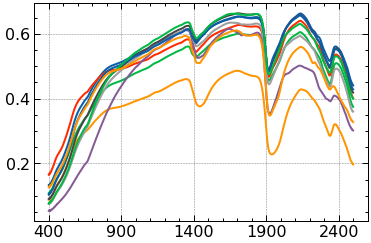

In [183]:
for i in range (0,10,1):
    cliped_spectra.iloc[i,:].plot()

## Moving average smoothing (not in use)

In [184]:
# # --------------- MOVING WINDOW SMOOTHING OF ORIGINAL SPECTRUM ------------   
# smoothed_spec ={}
# for i in range (1,120,1):
#     smoothed_spec[i] = sgsmooth (spectra,i)
    

# for i in range (1,120,1):
#     smoothed_spec[i] = smoothed_spec[i].iloc[:,50:2151]
    

# for i in range (0,10,1):
#     smoothed_spec[100].iloc[i,:].plot()    

## First Order Derivative

In [185]:
def fod (spectra):
    fo_spec = spectra.iloc[:,:].copy()
    (row,col) = fo_spec.shape
    
    for i in range(0,col):
        if i==col-1:
            fo_spec.iloc[:,i] = fo_spec.iloc[:,i-1]
        else:    
            fo_spec.iloc[:,i] = (spectra.iloc[:,i+1]- spectra.iloc[:,i])
        
    fo_spec = 100*fo_spec
    return(fo_spec.copy())

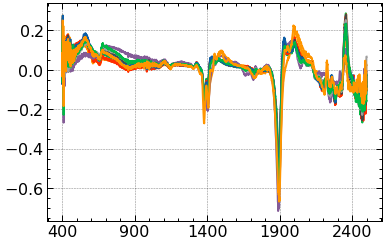

In [186]:
fod_spec = fod(spec2[51])

for i in range (0,10,1):
    fod_spec.iloc[i,:].plot()


In [187]:
fod1 = {}
for i in window_lengths:
    fod1[i] = filt_sg(fod_spec, i, 'sg1')
    
fod2 = {}
for i in window_lengths:
    fod2[i] = filt_sg(fod_spec, i, 'sg2') 

## Continuum Removal

In [188]:
def continuum_removal(points, show=False):
    x1, y1 = points.T
    augmented = np.concatenate([points, [(x1[0], np.min(y1)-1), (x1[-1], np.min(y1)-1)]], axis=0)
    hull = ConvexHull(augmented)
    continuum_points = points[np.sort([v for v in hull.vertices if v < len(points)])]
    continuum_function = interp1d(*continuum_points.T)
    yprime = continuum_function(x1) - y1
    #yprime = y1 / continuum_function(x1)

    if show:
        fig, axes = plt.subplots(2, 1, sharex=True)
        axes[0].plot(x1, y1, label='Data')
        axes[0].plot(*continuum_points.T, label='Continuum')
        axes[0].legend()
        axes[1].plot(x1, yprime, label='Data / Continuum')
        axes[1].legend()

    return yprime


def continuum_removed(spectra):
    cr_spec = spectra.copy()
    
    x1 = np.arange (loc_min, loc_max+1, 1)
    row, col = spectra.shape
    
    for r in range(0,row,1):
        y1 = cr_spec.iloc[r,:]
        points = np.c_[x1, y1]
        yprime = continuum_removal(points, show=False)
        cr_spec.iloc[r,:] = yprime
        
    return cr_spec

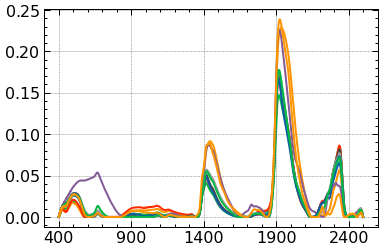

In [189]:
cr_spec = continuum_removed(spec2[51])

for i in range (0,10,1):
    cr_spec.iloc[i,:].plot()
    

In [190]:
cr1 = {}
for i in window_lengths:
    cr1[i] = filt_sg(cr_spec, i, 'sg1')
    
cr2 = {}
for i in window_lengths:
    cr2[i] = filt_sg(cr_spec, i, 'sg2')  
 

## Resampling (n_bands)

In [192]:
def resample_spectra (spectra, n_band):
    #row, width = alldata_smoothed.shape
    if n_band == 0:
        red_spectra = spectra.copy()
    else:
        w = (c_max-c_min)/n_band
        
        #----- obtaining the sampling locations in indx----
        indx = []
        for i in range (0,n_band,1):
            indx.append(np.floor((i+0.5)*w))
            
        #------ applying smoothing filter on spectra---------
        temp_smooth = sgsmooth (spectra, np.floor(0.5*w).astype(int))
        
        #------ picking values at sampling locations---------
        red_spectra = temp_smooth.iloc[:, indx].copy()
        
    return (red_spectra)

### 1. Sampled Original (sampled_spec: sampled clipped_spectra)

In [198]:
sampled_spec = {}
for w in nbands_sampling:
    sampled_spec[w] = resample_spectra (clipped_spectra, w)

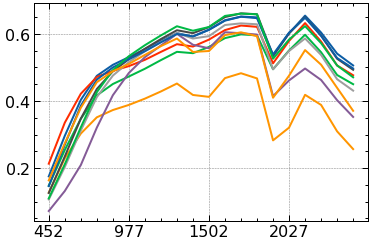

In [199]:
for i in range (0,10,1):
    sampled_spec[20].iloc[i,:].plot()

### 2. Sampled Continuum Removed  (sampled_cr)

In [200]:
sampled_cr = {}
for w in nbands_sampling:
    sampled_cr[w] = resample_spectra (cr_spec, w)

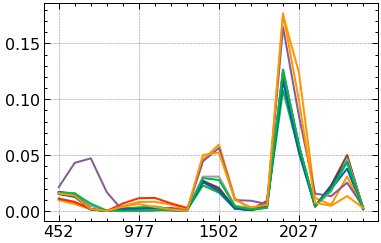

In [203]:
for i in range (0,10,1):
    sampled_cr[20].iloc[i,:].plot()

### 3. Sampled FOD  (sampled_fod)

In [204]:
sampled_fod = {}
for w in nbands_sampling:
    sampled_fod[w] = resample_spectra (fod_spec, w)

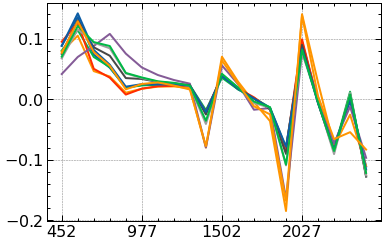

In [207]:
for i in range (0,10,1):
    sampled_fod[20].iloc[i,:].plot()

## Visualizing Processed Spectrum (variable samples)

In [208]:
def plot_spec (sample, process):
    x1 = spec2[51].iloc[sample,:]
    x1.plot()
    if process == 'continuum':
        x2 = cr_spec.iloc[sample,:]
        x2.plot()
    else: 
        x3 = fod_spec.iloc[sample,:]/1.5
        x3.plot()
    plt.ylim([-0.6, 0.8])

ipywidgets.interact(plot_spec, sample = (0, 293,1), process = ['fod', 'continuum'])

interactive(children=(IntSlider(value=146, description='sample', max=293), Dropdown(description='process', opt…

<function __main__.plot_spec(sample, process)>

# Step 1b: Target  Preprocessing (Outliers removal and Normalization)

In [209]:
df = pd.read_csv('uae.csv')
# ------------- Target Isolation ----------------------

clr = ['#F4A460', '#8B7355', '#A52A2A', 'green']

def isolate_targets(df, target_names):
    T=[]
    for i in range (0,len(target_names)):
        T.append(df[target_names[i]])
    return(T)
    
T = isolate_targets(df,target_names) 


# --- TODO : Also define and Use other normalisation methods ----
def normalize_targets(T):          
    NT =[]
    for i in range(0, len(T)):
        NT.append(lognormal(T[i].copy()))
    return(NT)

NT = normalize_targets(T)


## Correlation between wavelengths and Targets

In [210]:
plt.style.use(['science','notebook','grid'])
# Pearson corelation between different wavelengths and Targets/Outputs (i.e, sand, clay, silt, and TOC) 

def find_rpval (spectra, T):
    r_val = []
    p_val = []
    for i in range (0,len(T)):
        p_val.append(spectra.loc[[0],:].copy())
        r_val.append(spectra.loc[[0],:].copy())
        for j in range(c_min, c_max+1):
            r_val[i].iloc[0,j], p_val[i].iloc[0,j] = stats.pearsonr(T[i], spectra.iloc[:, j])
    return(r_val, p_val)

r_val, p_val = find_rpval (spectra, T)

light_blue = '#6495ED'
spec_std = 6*spectra.std()
mean_spec_std = spec_std.copy()
mean_spec_std.iloc[:] = spec_std.mean()

def plot_corr (target, mean_of_std):
    i = target_names.index(target)
    r_val[i].iloc[0,:].plot(color = clr[i])
    spec_std.plot(color = 'blue')
    if mean_of_std == 'on':
        mean_spec_std.plot(color = 'blue', linewidth=1, linestyle='dashed')
    plt.ylim([-0.6, 0.6])

ipywidgets.interact(plot_corr, target = target_names, mean_of_std= ['on', 'off'])

interactive(children=(Dropdown(description='target', options=('sand', 'silt', 'clay', 'TOC'), value='sand'), D…

<function __main__.plot_corr(target, mean_of_std)>

# Step 2:  Parameters for Best Train-Test Split  

In [211]:
# Building Mtree (Model Tree) ----------------------------------

tst_siz = 0.2

rand_t = [None] * (len(T))
err_t = [None] * (len(T))

print('Without Normalization:')
for i in range (0,len(T)):
    rand_t[i], err_t[i] = best_split(spectra.copy(), T[i], tst_siz) 
    print ('For '+ target_names[i]+ ' :test size =', tst_siz, '\t min bin error=', err_t[i], '\t at randome state =', rand_t[i])
    
rand_nt = [None] * (len(T))
err_nt = [None] * (len(T))

print('After Normalization:')
for i in range (0,len(T)):
    rand_nt[i], err_nt[i] = best_split(spectra.copy(), NT[i], tst_siz)     
    print ('For '+ target_names[i]+ ' :test size =', tst_siz, '\t min bin error=', err_nt[i], '\t at randome state =', rand_nt[i])
    
    

Without Normalization:
For sand :test size = 0.2 	 min bin error= 66.25 	 at randome state = 21
For silt :test size = 0.2 	 min bin error= 48.75 	 at randome state = 2
For clay :test size = 0.2 	 min bin error= 33.75 	 at randome state = 7
For TOC :test size = 0.2 	 min bin error= 41.25 	 at randome state = 24
After Normalization:
For sand :test size = 0.2 	 min bin error= 78.75 	 at randome state = 10
For silt :test size = 0.2 	 min bin error= 53.75 	 at randome state = 23
For clay :test size = 0.2 	 min bin error= 33.75 	 at randome state = 7
For TOC :test size = 0.2 	 min bin error= 66.25 	 at randome state = 1


# Step 3: Parameters for Best Model Fit 

## PLSR

In [214]:

from sklearn import linear_model

def best_param_PLSR (X_train, X_test, y_train, y_test, n_comp):
        
    iqrpL = []
    
    for n in range(1,n_comp):
        Model = PLSRegression(n_components=n, scale=True)
        Model.fit(X_train, y_train)
        y_pred = Model.predict(X_test, copy=True)
        
        iqrp_test = iqrp(y_pred, y_test)
#         r2_test = r2_score(y_test, y_pred)
#         rpd_test = y_test.std()/np.sqrt(mean_squared_error(y_test, y_pred))
               
        iqrpL.append(iqrp_test)
#         r2L.append(r2_test)
#         rpdL.append(rpd_test)
        
        
    
    IQRP = max(iqrpL)
    n_iqrp = iqrpL.index(max(iqrpL))+1
    
#     R2 = max(r2L)
#     n_r2 = r2L.index(R2)+1    
#     RPD = max(rpdL)
#     n_rpd = rpdL.index(RPD)+1
    
#    print('IQRP :', IQRP,  'R2 :', R2,  'RPD:', RPD, '>>> n_comp: ', n_iqrp, n_r2, n_rpd)    
    return (n_iqrp)
        
 

## Random Forest

# Step 4: Building Model Tree (Mtree)

In [215]:
import os
# os.system('say "your program has finished"')
import time

In [216]:
# 0. Available machine learning regression models --------------------------------- (7)
ml_methods = ['mult', 'plsr', 'randomforest']
#ml_methods = ['mult', 'plsr', 'cubist', 'randomforest', 'ridge' 'gbrt', 'svm']

In [217]:
def build_tree_for (method_name):
    tree ={}
    start = time.time()
    m = method_name
    #-- code to build tree----
    for t in target_names:
        
        if t == 'sand' and m == 'mult':
            os.system('say "tree for multilinear running on sand"')
        if t == 'silt' and m == 'mult':
            os.system('say "tree for multilinear running on silt"')
        if t == 'clay' and m == 'mult':
            os.system('say "tree for multilinear running on clay"')
        if t == 'TOC' and m == 'mult':
            os.system('say "tree for multilinear running on TOC"')
            
        if t == 'sand' and m == 'plsr':
            os.system('say "tree for plsr running on sand"')
        if t == 'silt' and m == 'plsr':
            os.system('say "tree for plsr running on silt"')
        if t == 'clay' and m == 'plsr':
            os.system('say "tree for plsr running on clay"')
        if t == 'TOC' and m == 'plsr':
            os.system('say "tree for plsr running on TOC"')
            
        if t == 'sand' and m == 'randomforest':
            os.system('say "tree for randomforest running on sand"')
        if t == 'silt' and m == 'randomforest':
            os.system('say "tree for randomforest running on silt"')
        if t == 'clay' and m == 'randomforest':
            os.system('say "tree for randomforest running on clay"')
        if t == 'TOC' and m == 'randomforest':
            os.system('say "tree for randomforest running on TOC"')    
            
            
        tree[t] ={}
        for tp in prepare_target:
            tree[t][tp] ={}
            for n in nbands_sampling:
                tree[t][tp][n] ={}
                for p in prepare_spec:
                    tree[t][tp][n][p] ={}
                    
                    #---- following case : either sampling or decision tree methods--
                    #---- in this case select appropriate sampled spectrum -------
                    if n!=0 or m == 'randomforest':
                        #------ case: sampling required-----------------------
                        Y = tree[t][tp][n][p]
                        
                        #------ seting spec to appropriate sampled spectra----
                        if p == 'none':
                            if n == 0:
                                #---- reched here due to randomforest--
                                spec = sampled_spec[100]
                            else:
                                #---- reached here with some n!=0----
                                spec = sampled_spec[n]
                        
                        elif p == 'fod':
                            if n == 0:
                                #---- reched here due to randomforest--
                                spec = sampled_fod[100]
                            else:
                                #---- reached here with some n!=0----
                                spec = sampled_fod[n]
                                
                        else:  
                            if n == 0:
                                #---- reched here due to randomforest--
                                spec = sampled_cr[100]
                            else:
                                #---- reached here with some n!=0----
                                spec = sampled_cr[n]
                        
                        #---- target selection and normalization ---
                        if tp == 'none':
                            y = T[target_names.index(t)]
                            rand_n = rand_t[target_names.index(t)]  #-- for future use in train-test split
                        else:
                            y = NT[target_names.index(t)]
                            rand_n = rand_nt[target_names.index(t)] #-- for future use in train-test split
                            #print('one more target set')
                            
                        #---- performing train-test split----------------------
                        X_train, X_test, y_train, y_test = train_test_split(spec, y, test_size= tst_siz, random_state=rand_n)
                            
                        #----- PLSR: best parameters, fitting, and prediction
                        if m == 'plsr':
                            n_com = best_param_PLSR (X_train, X_test, y_train, y_test, 10)
                            #print('one more n_comp', n_com)
                            Model = PLSRegression(n_components=n_com, scale=True)
                            Model.fit(X_train, y_train)
                            y_pred = Model.predict(X_test, copy=True)
                            yhat_pred = Model.predict(X_train, copy=True)
                                
                            Y['test'] = y_test
                            Y['testP'] = y_pred
                            Y['train'] = y_train
                            Y['trainP'] = yhat_pred
                            Y['n_comp'] = n_com
                                
                        #----- MULTILINEAR:  fitting, and prediction---------- 
                        if m == 'mult':
                            Model = linear_model.LinearRegression()
                            Model.fit(X_train, y_train)
                            y_pred = Model.predict(X_test)
                            yhat_pred = Model.predict(X_train)
                                
                            Y['test'] = y_test
                            Y['testP'] = y_pred
                            Y['train'] = y_train
                            Y['trainP'] = yhat_pred
                                
                        #----- RANDOM_FOREST:   fitting, and prediction---------- 
                        if m == 'randomforest': 
                            Model = RandomForestRegressor(random_state= 20)
                            Model.fit(X_train, y_train)
                            y_pred = Model.predict(X_test)
                            yhat_pred = Model.predict(X_train)
                                
                            Y['test'] = y_test
                            Y['testP'] = y_pred
                            Y['train'] = y_train
                            Y['trainP'] = yhat_pred
                            
                        
                    #---- following case: no sampling needed and model is not randomforest ---    
                    else: 
                        for sg in sg_filters:
                            tree[t][tp][n][p][sg] ={}
                            for w in window_lengths:
                                tree[t][tp][n][p][sg][w]={}
                                Y = tree[t][tp][n][p][sg][w]
                                
                                # -- optimal train test split----------------------------------------
                            
                                # -- deciding the smoothed spectra in present branch ---
                                if sg == 'sg1':
                                    spec = spec1[w]
                                else:
                                    spec = spec2[w]
                                
                                # -- preprocessing the spectra ------
                    
                                #--- no preprocessing ---------------
                                if p == 'none':
                                    spec = spec
                                
                                #--- first order derivative + smoothing------    
                                elif p == 'fod':
                                    if sg == 'sg1':
                                        spec = fod1[w]
                                    else:
                                        spec = fod2[w]
                                    #print('fod for one more case')
                                
                                #--- continuum removal + smoothing---------    
                                else: 
                                    if sg == 'sg1':
                                        spec = cr1[w]
                                    else:
                                        spec = cr2[w]
                                    #print('cr for one more case')
                            
                                
                                #---- target selection and normalization ---
                                if tp == 'none':
                                    y = T[target_names.index(t)]
                                    rand_n = rand_t[target_names.index(t)]  #-- for future use in train-test split
                                else:
                                    y = NT[target_names.index(t)]
                                    rand_n = rand_nt[target_names.index(t)] #-- for future use in train-test split
                                    #print('one more target set')
                            
                                #---- performing train-test split----------------------
                                X_train, X_test, y_train, y_test = train_test_split(spec, y, test_size= tst_siz, random_state=rand_n)
                            
                                
                                #----- PLSR: best parameters, fitting, and prediction
                                if m == 'plsr':
                                    n_com = best_param_PLSR (X_train, X_test, y_train, y_test, 10)
                                    #print('one more n_comp', n_com)
                                    Model = PLSRegression(n_components=n_com, scale=True)
                                    Model.fit(X_train, y_train)
                                    y_pred = Model.predict(X_test, copy=True)
                                    yhat_pred = Model.predict(X_train, copy=True)
                                
                                    Y['test'] = y_test
                                    Y['testP'] = y_pred
                                    Y['train'] = y_train
                                    Y['trainP'] = yhat_pred
                                    Y['n_comp'] = n_com
                                
                                #----- MULTILINEAR:  fitting, and prediction---------- 
                                if m == 'mult':
                                    Model = linear_model.LinearRegression()
                                    Model.fit(X_train, y_train)
                                    y_pred = Model.predict(X_test)
                                    yhat_pred = Model.predict(X_train)
                                
                                    Y['test'] = y_test
                                    Y['testP'] = y_pred
                                    Y['train'] = y_train
                                    Y['trainP'] = yhat_pred
                                
#                                 #----- RANDOM_FOREST:   fitting, and prediction---------- 
#                                 if m == 'randomforest': 
#                                     Model = RandomForestRegressor(random_state= 20)
#                                     Model.fit(X_train, y_train)
#                                     y_pred = Model.predict(X_test)
#                                     yhat_pred = Model.predict(X_train)
                                
#                                     Y['test'] = y_test
#                                     Y['testP'] = y_pred
#                                     Y['train'] = y_train
#                                     Y['trainP'] = yhat_pred
                    
                    
                      
     
    
    end = time.time()                            
    os.system('say "your program has finished"')                            

    print('End time - Start time =', (end-start)) 
    
    return (tree.copy())


In [218]:
Mtree ={}

In [219]:
Mtree['plsr'] = build_tree_for ('plsr')

End time - Start time = 197.71226596832275


In [220]:
Mtree['mult'] = build_tree_for ('mult')

End time - Start time = 262.4959228038788


In [221]:
Mtree['randomforest'] = build_tree_for ('randomforest')

End time - Start time = 160.0738251209259


## Ploting Model Accuracy (ipywidgets)

In [222]:
def plot_model_acc (target, method, smth_filt, window_len, spec_preprocessing, n_bands, target_preprocessing):
    
    m = method
    t = target
    
    i = target_names.index(target)
    
    sg = smth_filt
    w = window_len
    p = spec_preprocessing
    n = n_bands
    tp = target_preprocessing
    
    if n!=0 or m == 'randomforest':
        Y = Mtree[m][t][tp][n][p]
    else: 
        Y = Mtree[m][t][tp][n][p][sg][w]
    
    #Y = Mtree[m][t][sg][w][p][n][tp]
    y_test = Y['test']
    y_pred = Y['testP']
    y_train = Y['train']
    yhat_pred = Y['trainP']
    
    if m == 'plsr':
        n_com = Y['n_comp']
        y_pred = y_pred[:,0]
        yhat_pred = yhat_pred[:,0]
    
    iqrp_test = iqrp(y_pred, y_test)
    r2_test = r2_score(y_test, y_pred)
    rpd_test = y_test.std()/np.sqrt(mean_squared_error(y_test, y_pred))
    
    iqrp_train = iqrp(yhat_pred, y_train)
    r2_train = r2_score(y_train, yhat_pred)
    rpd_train = y_train.std()/np.sqrt(mean_squared_error(y_train, yhat_pred))
    
    y_tp = pd.DataFrame({'actual':y_test.values, 'predic': y_pred})
    z = np.polyfit(y_test, y_pred, 1)
    
    yhat_tp = pd.DataFrame({'actual':y_train.values, 'predic': yhat_pred})
    zhat = np.polyfit(y_train, yhat_pred, 1)
    
    fig, axes = plt.subplots(1,2, figsize=(18,8))
    
    #with plt.style.context(('ggplot')): ---- PLOT of test-prediction --------------------------------------
    y_tp.plot.scatter(ax= axes[0], x="actual", y="predic", alpha=0.8, color = clr[i], edgecolors='k')
    axes[0].plot(y_test, np.polyval(z, y_test),  c='blue', linewidth=1)
    axes[0].plot(y_test, y_test, color='green', linewidth=1)
    axes[0].tick_params(axis='both', labelsize=10)
    axes[0].text(0.05, 0.95, target_names[i]+' (Test Data)', transform=axes[0].transAxes, fontsize = 20, color = clr[i])
    axes[0].text(0.05, 0.90, 'IQRP ={:.2f}'.format(iqrp_test), transform=axes[0].transAxes, fontsize = 16)
    axes[0].text(0.05, 0.85, 'RPD ={:.2f}'.format(rpd_test), transform=axes[0].transAxes, fontsize = 16)
    axes[0].text(0.05, 0.80, 'R2 ={:.2f}'.format(np.round(r2_test,3)), transform=axes[0].transAxes, fontsize = 16)
    axes[0].text(0.95, 0.15, 'Method: '+method, transform=axes[0].transAxes, 
                    horizontalalignment='right', fontsize = 20)
    axes[0].text(0.95, 0.10, 'smoothing window={:.2f}'.format(w), transform=axes[0].transAxes, 
                    horizontalalignment='right', fontsize = 12)
    if method == 'plsr':
        axes[0].text(0.95, 0.05, 'n_component={:.2f}'.format(n_com), transform=axes[0].transAxes, 
                    horizontalalignment='right', fontsize = 12)
    
    #---------------------------------- ---- PLOT of train-prediction --------------------------------------
    yhat_tp.plot.scatter(ax= axes[1], x="actual", y="predic", alpha=0.8, color = clr[i], edgecolors='k')
    axes[1].plot(y_train, np.polyval(zhat, y_train),  c='blue', linewidth=1)
    axes[1].plot(y_train, y_train, color='green', linewidth=1)
    axes[1].tick_params(axis='both', labelsize=10)
    axes[1].text(0.05, 0.95,  target_names[i]+' (Training Data)', transform=axes[1].transAxes,fontsize = 20, color = clr[i])
    axes[1].text(0.05, 0.90, 'IQRP ={:.2f}'.format(iqrp_train), transform=axes[1].transAxes, fontsize = 16)
    axes[1].text(0.05, 0.85, 'RPD ={:.2f}'.format(rpd_train), transform=axes[1].transAxes, fontsize = 16)
    axes[1].text(0.05, 0.80, 'R2 ={:.2f}'.format(np.round(r2_train,3)), transform=axes[1].transAxes, fontsize = 16)
    axes[1].text(0.95, 0.15, 'Method: '+method, transform=axes[1].transAxes, 
                    horizontalalignment='right', fontsize = 20)
    axes[1].text(0.95, 0.10, 'smoothing window={:.2f}'.format(w), transform=axes[1].transAxes, 
                    horizontalalignment='right', fontsize = 12)
        
    

In [223]:
ipywidgets.interact(plot_model_acc, target = target_names, method = ml_methods, smth_filt = sg_filters, 
                    window_len = window_lengths, spec_preprocessing = prepare_spec, n_bands = nbands_sampling, 
                    target_preprocessing = prepare_target)

interactive(children=(Dropdown(description='target', options=('sand', 'silt', 'clay', 'TOC'), value='sand'), D…

<function __main__.plot_model_acc(target, method, smth_filt, window_len, spec_preprocessing, n_bands, target_preprocessing)>

In [ ]:
# 1. Available smoothing filter types: savgol1 and savgol2 ------------------------ (1)
sg_filters = ['sg1', 'sg2']

# 2. Available window lengths for the smoothing filter ---------------------------- (2)
window_lengths = [0, 1, 3, 5, 7, 9, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101]

# 3. Available preprocessing for Spectral data ------------------------------------ (3)
prepare_spec = ['none', 'fod', 'continuum']
#prepare_spec = ['none', 'fod', 'continuum']

# 4. Number of bands available for resampling spectra ----------------------------- (4) 
nbands_sampling = [10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# 5. Names of target variables in the dataframe ----------------------------------- (5)
target_names = ['sand', 'silt', 'clay', 'TOC']

# 6. Available preprocessing for Target data -------------------------------------- (6)
prepare_target = ['none', 'minmax']

# 0. Available machine learning regression models --------------------------------- (7)
ml_methods = ['mult', 'plsr']
#ml_methods = ['mult', 'plsr', 'cubist', 'randomforest', 'ridge' 'gbrt', 'svm']

# 8. Recorded predictions on test-train data for model accuracy  ------------------ (8)
test_train_predict = ['test', 'testP', 'train', 'trainP']


##  Visualizing the Optimal Test Train Split 

In [14]:
def best_split_plot (target):
    
    i = target_names.index(target)
    
    X_train, X_test, y_train, y_test = train_test_split(spectra, T[i], test_size= tst_siz, random_state=rand_t[i])
    NX_train, NX_test, Ny_train, Ny_test = train_test_split(spectra, NT[i], test_size= tst_siz, random_state=rand_nt[i])
    
    fig, ax = plt.subplots(1,2, figsize=(18,7))
    
    binsT = np.linspace(np.min(T[i]), np.max(T[i]),10)
    ax[0].hist([y_train, y_test], binsT , label=['Train', 'Test'], density=True, color = ['blue','red'])
    ax[0].legend(loc='upper center', fontsize =12)
    ax[0].set_xlabel(target_names[i]+' content',fontsize =16)
    ax[0].set_ylabel('Normalised frequency',fontsize =12)
    ax[0].tick_params(axis='both', labelsize=8)
    
    binsNT = np.linspace(np.min(NT[i]), np.max(NT[i]),10)
    ax[1].hist([Ny_train, Ny_test], binsNT , label=['Train', 'Test'], density=True, color = ['blue','red'])
    ax[1].legend(loc='upper center', fontsize =12)
    ax[1].set_xlabel('Normalised '+target_names[i]+' content',fontsize =16)
    ax[1].set_ylabel('Normalised frequency',fontsize =12)
    ax[1].tick_params(axis='both', labelsize=8)

    fig.suptitle('Train Test Distribution of Data', x = 0.5 ,y = .95, fontsize = 20)
    

ipywidgets.interact(best_split_plot, target = target_names)


interactive(children=(Dropdown(description='target', options=('sand', 'silt', 'clay', 'TOC'), value='sand'), O…

<function __main__.best_split_plot(target)>

# Step 3: Best Model Parameters (window, n_components)

## PLSR: obtaining best parameter (window, n_components, IQRP)

In [110]:
# w1, n1, IQRP1 = best_param_PLSR (smth_spec.copy(), T[3], rand_t[3], 0.2, 5,30)
# w1, n1, IQRP1 = best_param_PLSR (smth_spec.copy(), NT[3], rand_nt[3], 0.2, 5,30)

##  Multilinear: obtaining best parameters(window and IQRP)

In [134]:
#w1, IQRP1 = best_param_Mult (smth_spec.copy(), T[1], rand_t[1], 0.2, 5)
# w1,  IQRP1 = best_param_Mult (smth_spec.copy(), NT[1], rand_nt[1], 0.2, 45)

## RandomForest: obtaining best parameters(window and IQRP)

In [154]:
rf_reg = RandomForestRegressor()

#to generate various random forests.
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 5)]
max_depth = [2,4]
max_features = ['sqrt', 'auto']
min_samples_split = [4,6]
bootstrap = ['True']

# Create the random grid
random_grid = {'n_estimators': n_estimators, 'max_depth': max_depth, 'max_features':max_features,\
              'min_samples_split':min_samples_split, 'min_samples_leaf':min_samples_leaf,\
               'bootstrap':bootstrap}

print(random_grid)

scorer = make_scorer(mean_squared_error, greater_is_better=False)
cv = RepeatedKFold(n_splits=4, n_repeats=4, random_state=10)
rf_random = RandomizedSearchCV(estimator=rf_reg, param_distributions = random_grid, cv = cv, n_iter = 100,\
                            scoring=scorer, verbose=1, random_state = 30, error_score='raise', n_jobs=-1)
 
red_spec = resample_spectra(spectra,10)
X= 10*(red_spec.copy())
y= T[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = tst_siz, random_state=rand_t[0])

rf_random.fit(X_train, y_train)

{'n_estimators': [10, 20, 30, 40, 50], 'max_depth': [2, 4], 'max_features': ['sqrt', 'auto'], 'min_samples_split': [4, 6], 'min_samples_leaf': [1, 2, 4], 'bootstrap': ['True']}
Fitting 16 folds for each of 100 candidates, totalling 1600 fits


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=4, n_splits=4, random_state=10),
                   error_score='raise', estimator=RandomForestRegressor(),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': ['True'],
                                        'max_depth': [2, 4],
                                        'max_features': ['sqrt', 'auto'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [4, 6],
                                        'n_estimators': [10, 20, 30, 40, 50]},
                   random_state=30,
                   scoring=make_scorer(mean_squared_error, greater_is_better=False),
                   verbose=1)

In [155]:
y_pred = rf_random.predict(X_test)
iqrp_sand = iqrp(y_pred, y_test)
iqrp_sand

1.6137614723416303

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, NT[0], test_size = tst_siz, random_state=rand_nt[0])

rf_random.fit(X_train, y_train)

Fitting 16 folds for each of 100 candidates, totalling 1600 fits


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=4, n_splits=4, random_state=10),
                   error_score='raise', estimator=RandomForestRegressor(),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': ['True'],
                                        'max_depth': [2, 4],
                                        'max_features': ['sqrt', 'auto'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [4, 6],
                                        'n_estimators': [10, 20, 30, 40, 50]},
                   random_state=10,
                   scoring=make_scorer(mean_squared_error, greater_is_better=False),
                   verbose=1)

In [90]:
y_pred = rf_random.predict(X_test)
iqrp_sand = iqrp(y_pred, y_test)
iqrp_sand

1.5407993064557126

### Support Vector Machine for Regression

In [152]:
sv_reg = SVR()
random_grid = {'C': [0.00001, 0.00005, 0.0001, 0.0005,0.001, 0.005, 0.01, 0.05, 0.1], 'gamma': [1, 0.1, 0.5, 0.05, 0.01, 0.001, 0.005],\
             'kernel': [ 'poly', 'rbf', 'sigmoid'], 'degree':[2, 3, 4]}

scorer = make_scorer(mean_squared_error, greater_is_better=False)
cv = RepeatedKFold(n_splits=4, n_repeats=4)
svr_random = RandomizedSearchCV(estimator=sv_reg, param_distributions = random_grid, cv = cv, n_iter = 100,\
                            scoring=scorer, verbose=1, random_state = 32, error_score='raise', n_jobs=-1)

#svr_random.fit(X_train,y_train)

red_spec = resample_spectra(spectra,25)
X= red_spec.copy()
y= T[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = tst_siz, random_state=rand_t[0])

svr_random.fit(X_train, y_train)

Fitting 16 folds for each of 100 candidates, totalling 1600 fits


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=4, n_splits=4, random_state=None),
                   error_score='raise', estimator=SVR(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [1e-05, 5e-05, 0.0001, 0.0005,
                                              0.001, 0.005, 0.01, 0.05, 0.1],
                                        'degree': [2, 3, 4],
                                        'gamma': [1, 0.1, 0.5, 0.05, 0.01,
                                                  0.001, 0.005],
                                        'kernel': ['poly', 'rbf', 'sigmoid']},
                   random_state=32,
                   scoring=make_scorer(mean_squared_error, greater_is_better=False),
                   verbose=1)

In [153]:
y_pred = svr_random.predict(X_test)
iqrp_sand = iqrp(y_pred, y_test)
iqrp_sand

1.4688770094225434

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, NT[0], test_size = tst_siz, random_state=rand_nt[0])

svr_random.fit(X_train, y_train)

Fitting 16 folds for each of 100 candidates, totalling 1600 fits


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=4, n_splits=4, random_state=None),
                   error_score='raise', estimator=SVR(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [1e-05, 5e-05, 0.0001, 0.0005,
                                              0.001, 0.005, 0.01, 0.05, 0.1],
                                        'degree': [2, 3, 4],
                                        'gamma': [1, 0.1, 0.5, 0.05, 0.01,
                                                  0.001, 0.005],
                                        'kernel': ['poly', 'rbf', 'sigmoid']},
                   random_state=32,
                   scoring=make_scorer(mean_squared_error, greater_is_better=False),
                   verbose=1)

In [183]:
y_pred = rf_random.predict(X_test)
iqrp_sand = iqrp(y_pred, y_test)
iqrp_sand

1.5534179516586588

## Gradient Boosting Regression Tree

In [177]:
gb_reg = GradientBoostingRegressor()

n_estimators = [5000]
max_depth = [3,4]
min_samples_split = [3, 5, 6]
learning_rate = [0.05]
loss = ["squared_error"]
subsample = [0.5]
validation_fraction =[0.1]
n_iter_no_change =[20, 25]
max_features = ['log2','sqrt']
    
    
# Create the random grid
random_grid = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split, \
               'learning_rate': learning_rate, 'loss': loss, 'subsample': subsample, 'validation_fraction': validation_fraction, \
               'n_iter_no_change': n_iter_no_change, 'max_features':max_features}
    
print(random_grid)

scorer = make_scorer(mean_squared_error, greater_is_better=False)
cv = RepeatedKFold(n_splits=4, n_repeats=4, random_state=10)
gb_random = RandomizedSearchCV(estimator=gb_reg, param_distributions = random_grid, cv = cv, n_iter = 100,\
                            scoring=scorer, verbose=1, random_state = 42, error_score='raise', n_jobs=-1)


red_spec = resample_spectra(spectra,25)
X= red_spec.copy()
y= T[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = tst_siz, random_state=rand_t[0])

gb_random.fit(X_train, y_train)

{'n_estimators': [5000], 'max_depth': [3, 4], 'min_samples_split': [3, 5, 6], 'learning_rate': [0.05], 'loss': ['squared_error'], 'subsample': [0.5], 'validation_fraction': [0.1], 'n_iter_no_change': [20, 25], 'max_features': ['log2', 'sqrt']}
Fitting 16 folds for each of 24 candidates, totalling 384 fits


C:\Users\abhis\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 24 is smaller than n_iter=100. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=4, n_splits=4, random_state=10),
                   error_score='raise', estimator=GradientBoostingRegressor(),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.05],
                                        'loss': ['squared_error'],
                                        'max_depth': [3, 4],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_split': [3, 5, 6],
                                        'n_estimators': [5000],
                                        'n_iter_no_change': [20, 25],
                                        'subsample': [0.5],
                                        'validation_fraction': [0.1]},
                   random_state=42,
                   scoring=make_scorer(mean_squared_error, greater_is_better=False),
                   verbose=1)

In [178]:
y_pred = gb_random.predict(X_test)
iqrp_sand = iqrp(y_pred, y_test)
iqrp_sand

1.5859981443246949

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, NT[0], test_size = tst_siz, random_state=rand_nt[0])

gb_random.fit(X_train, y_train)

C:\Users\abhis\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 24 is smaller than n_iter=100. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 16 folds for each of 24 candidates, totalling 384 fits


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=4, n_splits=4, random_state=10),
                   error_score='raise', estimator=GradientBoostingRegressor(),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.05],
                                        'loss': ['squared_error'],
                                        'max_depth': [3, 4],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_split': [3, 5, 6],
                                        'n_estimators': [5000],
                                        'n_iter_no_change': [20, 25],
                                        'subsample': [0.5],
                                        'validation_fraction': [0.1]},
                   random_state=42,
                   scoring=make_scorer(mean_squared_error, greater_is_better=False),
                   verbose=1)

In [181]:
y_pred = rf_random.predict(X_test)
iqrp_sand = iqrp(y_pred, y_test)
iqrp_sand

1.5534179516586588

## Visualizing Model Accuracy (PLSR)

In [ ]:
spectra = udf.iloc[:, 7:2158].copy()
w1, n1, IQRP1 = best_param_PLSR (spectra, y_sand, rand_sand, 0.2, 3,20)

In [ ]:
spectra = udf.iloc[:, 7:2158].copy()
w2, n2, IQRP2 = best_param_PLSR (spectra, y_silt, rand_silt, 0.2, 3,20)  

In [ ]:
spectra = udf.iloc[:, 7:2158].copy()
w3, n3, IQRP3 = best_param_PLSR (spectra, y_clay, rand_clay, 0.2, 3,20)

In [ ]:
spectra = udf.iloc[:, 7:2158].copy()
w4, n4, IQRP4 = best_param_PLSR (spectra, y_toc, rand_toc, 0.2, 3, 20)

# Step 4: Training the Model

        - Create a linear regr object
        - Apply fit function (using regr object) on training data
        - Check the weights/parameters generated by fit function 

# Step 5: Prediction on Test Data 

# Step 6: Model Accuracy and Plots